In [8]:
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))


GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Veri artırma işlemi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=70,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Veri yükleyiciler
train_generator = train_datagen.flow_from_directory(
    'Organized_Damage_Level/train',
    target_size=(128, 128),  # Daha küçük görüntü boyutu
    batch_size=16,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    'Organized_Damage_Level/valid',
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical'
)

# Sınıf sayısını kontrol et
num_classes = len(train_generator.class_indices)
print("Sınıf Sayısı:", num_classes)
print("Sınıf İndeksleri:", train_generator.class_indices)

# Modeli oluştur
model = Sequential()

# İlk Convolution Katmanı
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

# İkinci Convolution Katmanı
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

# Flatten ve Yoğun Katmanlar
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))  # 4 sınıf için çıkış katmanı

# Modeli derle
model.compile(optimizer=Adam(learning_rate=5e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)



Found 3427 images belonging to 4 classes.
Found 1096 images belonging to 4 classes.
Sınıf Sayısı: 4
Sınıf İndeksleri: {'Heavy Damage': 0, 'Minor Damage': 1, 'Moderate Damage': 2, 'Undamage': 3}


In [17]:
# Modeli eğit
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=40,
    callbacks=[reduce_lr, early_stop]
)


Epoch 1/40
215/215 [==============================] - 11s 48ms/step - loss: 1.6133 - accuracy: 0.4079 - val_loss: 1.5919 - val_accuracy: 0.4206 - lr: 5.0000e-05
Epoch 2/40
215/215 [==============================] - 10s 47ms/step - loss: 1.2737 - accuracy: 0.4243 - val_loss: 2.3688 - val_accuracy: 0.2190 - lr: 5.0000e-05
Epoch 3/40
215/215 [==============================] - 10s 47ms/step - loss: 1.2304 - accuracy: 0.4467 - val_loss: 1.5099 - val_accuracy: 0.4124 - lr: 5.0000e-05
Epoch 4/40
215/215 [==============================] - 10s 47ms/step - loss: 1.2422 - accuracy: 0.4465 - val_loss: 1.3692 - val_accuracy: 0.4270 - lr: 5.0000e-05
Epoch 5/40
215/215 [==============================] - 10s 47ms/step - loss: 1.1939 - accuracy: 0.4537 - val_loss: 1.2973 - val_accuracy: 0.4489 - lr: 5.0000e-05
Epoch 6/40
215/215 [==============================] - 10s 48ms/step - loss: 1.2106 - accuracy: 0.4564 - val_loss: 1.3023 - val_accuracy: 0.4754 - lr: 5.0000e-05
Epoch 7/40
215/215 [==============

In [ ]:
# Eğitim ve doğrulama sonuçlarını kaydetme
model.save('damage_classification_model_augmented.h5')

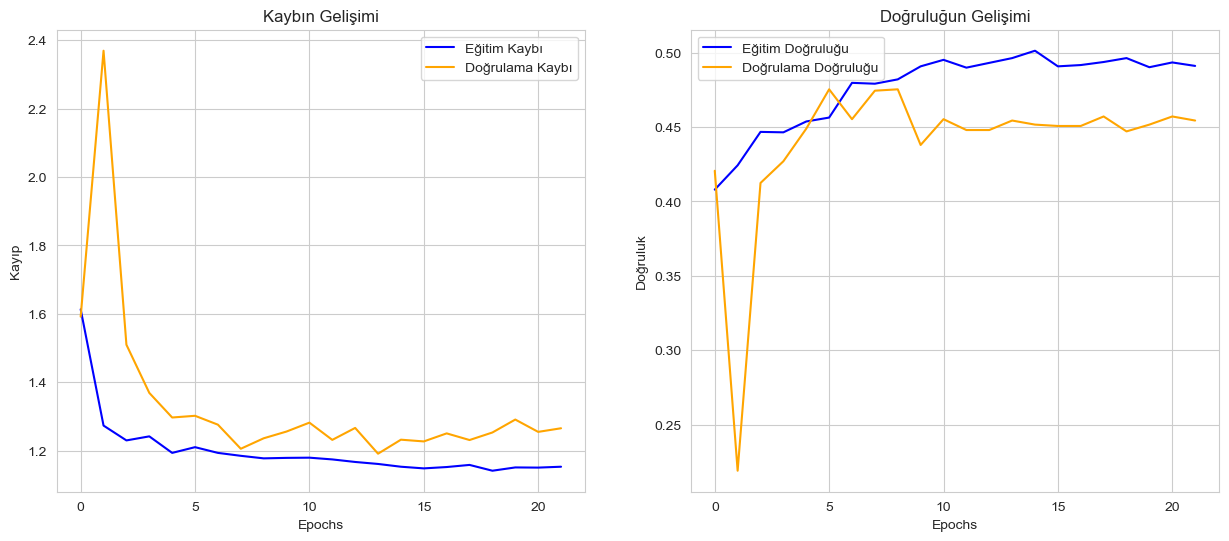

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Eğitim ve doğrulama sonuçlarını görselleştirme
plt.figure(figsize=(15, 6))

# Kayıp değerlerini çiz
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı', color='blue')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı', color='orange')
plt.legend()
plt.title('Kaybın Gelişimi')
plt.xlabel('Epochs')
plt.ylabel('Kayıp')

# Doğruluk değerlerini çiz
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu', color='blue')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu', color='orange')
plt.legend()
plt.title('Doğruluğun Gelişimi')
plt.xlabel('Epochs')
plt.ylabel('Doğruluk')

plt.show()



69/69 [==============================] - 1s 14ms/step


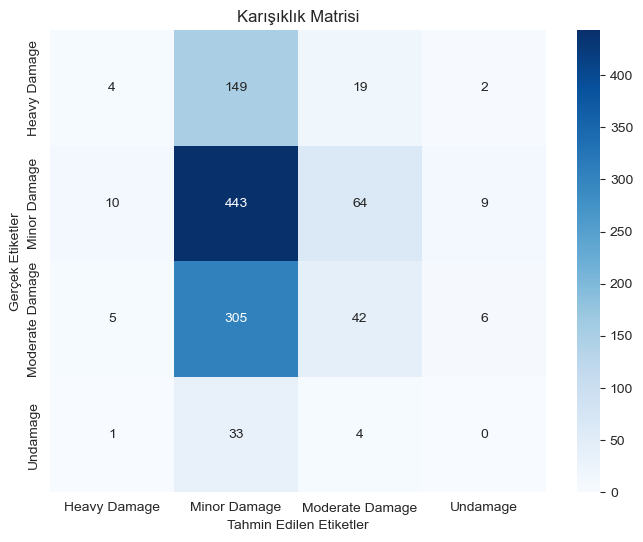

Sınıflandırma Raporu:
                  precision    recall  f1-score   support

   Heavy Damage       0.20      0.02      0.04       174
   Minor Damage       0.48      0.84      0.61       526
Moderate Damage       0.33      0.12      0.17       358
       Undamage       0.00      0.00      0.00        38

       accuracy                           0.45      1096
      macro avg       0.25      0.25      0.21      1096
   weighted avg       0.37      0.45      0.35      1096



In [19]:
# Karışıklık matrisi ve sınıflandırma raporu
validation_generator.reset()  # Validasyon veri yükleyiciyi sıfırla
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Gerçek etiketleri al
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Karışıklık matrisi
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Karışıklık Matrisi')
plt.xlabel('Tahmin Edilen Etiketler')
plt.ylabel('Gerçek Etiketler')
plt.show()

# Sınıflandırma raporu
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Sınıflandırma Raporu:\n", report)
